In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, calculate, equilibrium, binplot, Model, ReferenceState
import pycalphad.variables as v

# Load database and choose the phases that will be considered
db = Database('PdZn_2006.tdb')
comps = ['PD', 'ZN', 'VA']
phases = ['LIQUID', 'FCC_A1', 'HCP_ZN', 'HCP_A3', 'CO2SI_TYPE', 'PDZN_1BETA', 'PDZN_BETA', 'PDZN_ETA', 'PDZN_GAMMA', 'PDZN2']

/srv/conda/envs/notebook/lib/python3.7/site-packages/pycalphad/io/tdb.py:964: UserWarning: The type definition character `*` was defined in the following phases: ['BCC_A2'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


/srv/conda/envs/notebook/lib/python3.7/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum


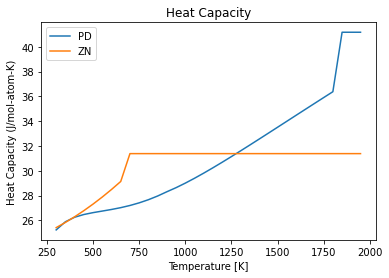

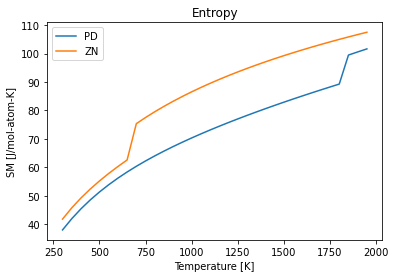

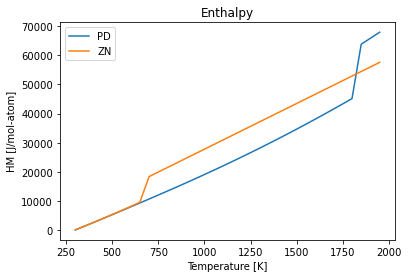

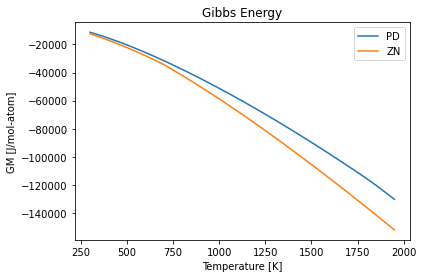

<Figure size 432x288 with 0 Axes>

In [3]:
pd_phases = ['LIQUID', 'FCC_A1']
zn_phases = ['LIQUID', 'HCP_ZN']
eq_pd = equilibrium(db, comps, pd_phases, {v.N: 1, v.X('PD'): 1, v.T: (300, 2000, 50), v.P: 101325}, output=['heat_capacity', 'GM', 'HM', 'SM'])
eq_zn = equilibrium(db, comps, zn_phases, {v.N: 1, v.X('ZN'): 1, v.T: (300, 2000, 50), v.P: 101325}, output=['heat_capacity', 'GM', 'HM', 'SM'])

plt.plot(eq_pd['T'].values, np.squeeze(eq_pd['heat_capacity'].values), label='PD')
plt.plot(eq_zn['T'].values, np.squeeze(eq_zn['heat_capacity'].values), label='ZN')
plt.title("Heat Capacity")
plt.xlabel("Temperature [K]")
plt.ylabel("Heat Capacity (J/mol-atom-K)")
plt.legend()
plt.show()
plt.savefig('Pd-Zn Heat Capacity')

plt.plot(eq_pd['T'].values, np.squeeze(eq_pd['SM'].values), label='PD')
plt.plot(eq_zn['T'].values, np.squeeze(eq_zn['SM'].values), label='ZN')
plt.title("Entropy")
plt.xlabel("Temperature [K]")
plt.ylabel("SM [J/mol-atom-K]")
plt.legend()
plt.show()
plt.savefig('Pd-Zn Entropy')

plt.plot(eq_pd['T'].values, np.squeeze(eq_pd['HM'].values), label='PD')
plt.plot(eq_zn['T'].values, np.squeeze(eq_zn['HM'].values), label='ZN')
plt.title("Enthalpy")
plt.xlabel("Temperature [K]")
plt.ylabel("HM [J/mol-atom]")
plt.legend()
plt.show()
plt.savefig('Pd-Zn Enthalpy')

plt.plot(eq_pd['T'].values, np.squeeze(eq_pd['GM'].values), label='PD')
plt.plot(eq_zn['T'].values, np.squeeze(eq_zn['GM'].values), label='ZN')
plt.title("Gibbs Energy")
plt.xlabel("Temperature [K]")
plt.ylabel("GM [J/mol-atom]")
plt.legend()
plt.show()
plt.savefig('Pd-Zn Gibbs Energy')

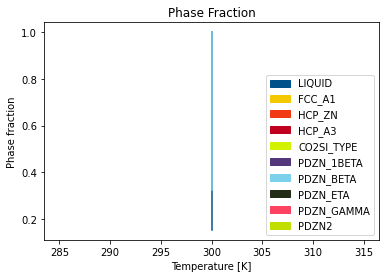

<Figure size 432x288 with 0 Axes>

In [4]:
#phase fractions
eq_pf = equilibrium(db, comps, phases, {v.N: 1, v.X('ZN'): 0.5, v.T: (300, 2000, 50), v.P: 101325})
from pycalphad.plot.utils import phase_legend
phase_handles, phasemap = phase_legend(phases)

#plt.plot(eq_pf.T, eq_pf.NP.squeeze())
#plt.title('Pd-Zn: Phase fractions vs T [X(ZN)=0.5]')
#plt.xlabel('Temperature (K)')
#plt.ylabel('Phase Fraction')

for name in phases:
    phase_indices = np.nonzero(eq_pf.Phase.values == name)
    plt.plot(np.take(eq_pf['T'].values, phase_indices[1]), eq_pf.NP.values[phase_indices], color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')
plt.title("Phase Fraction")
plt.xlabel("Temperature [K]")
plt.ylabel("Phase fraction")
plt.show()
plt.savefig('Pd-Zn Phase Fraction')

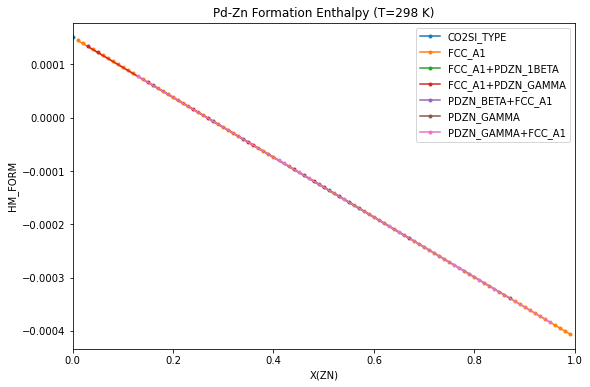

<Figure size 432x288 with 0 Axes>

In [6]:
#enthalpy of formation at 298 K
pd_ref = ReferenceState("PD", "FCC_A1", {v.T: 298.15, v.P: 101325})
zn_ref = ReferenceState("ZN", "HCP_ZN", {v.T: 298.15, v.P: 101325})

eq_models = {}
for phase_name in phases:
    mod = Model(db, comps, phase_name)
    mod.shift_reference_state([pd_ref, zn_ref], db)
    eq_models[phase_name] = mod
    
conds = {v.P: 101325, v.T: 298, v.X("ZN"): (0, 1, 0.01)}
result = equilibrium(db, comps, phases, conds, output="HMR", model=eq_models)

unique_phase_sets = np.unique(result.Phase.values.squeeze(), axis=0)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same unique phase
    unique_phase_idx = np.nonzero(np.all(result.Phase.values.squeeze() == phase_set, axis=1))[0]
    masked_result = result.isel(X_ZN=unique_phase_idx)
    ax.plot(masked_result.X_ZN.squeeze(), masked_result.HMR.squeeze(), marker='.', label=label)
ax.set_xlim((0, 1))
ax.set_xlabel('X(ZN)')
ax.set_ylabel('HM_FORM')
ax.set_title('Pd-Zn Formation Enthalpy (T=298 K)')
ax.legend()
plt.show()
plt.savefig('Pd-Zn Formation Enthalpy')

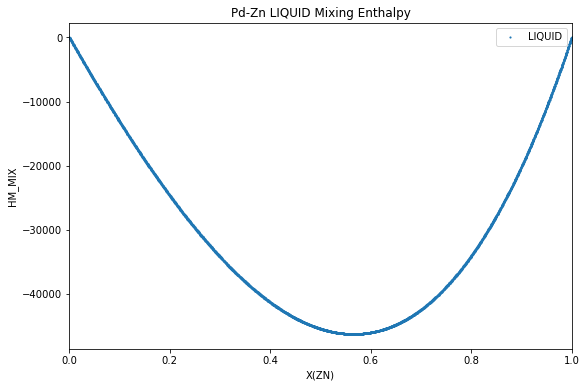

In [7]:
#enthalpy of mixing in he liquid phase at 1900 K
pd_ref_liq = ReferenceState("PD", "LIQUID")
zn_ref_liq = ReferenceState("ZN", "LIQUID")
liq_refstates = [pd_ref_liq, zn_ref_liq]

mod_liq = Model(db, comps, "LIQUID")
mod_liq.shift_reference_state(liq_refstates, db)
calc_models = {"LIQUID": mod_liq}

conds = {v.P: 101325, v.T: 1900, v.X("ZN"): (0, 1, 0.01)}
result = calculate(db, comps, "LIQUID", P=101325, T=1900, output="HMR", model=calc_models)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.scatter(result.X.sel(component='ZN'), result.HMR, marker='.', s=5, label='LIQUID')
ax.set_xlim((0, 1))
ax.set_xlabel('X(ZN)')
ax.set_ylabel('HM_MIX')
ax.set_title('Pd-Zn LIQUID Mixing Enthalpy')
ax.legend()
plt.show()

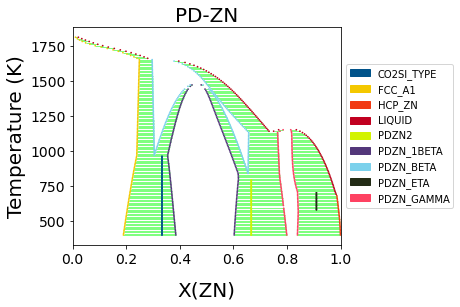

In [8]:
#phase diagram
binplot(db, comps, phases, {v.N: 1, v.P:101325, v.T: (400, 2000, 10), v.X('ZN'):(0, 1, 0.02)})

plt.show()